<a href="https://colab.research.google.com/github/iNuman/PytorchDeepLearnignPlayGround/blob/main/FacialExpressionRecognitionPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Facial recognitions
#  "https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset"

In [3]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vy_tqilm
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vy_tqilm
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [5]:
# Configurations
TRAIN_IMG_FOLDER_PATH = "/content/Facial-Expression-Dataset/train"
VALID_ING_FOLDER_PATH = "/content/Facial-Expression-Dataset/validation"

LR = 0.01
BATCH_SIZE = 32
EPOCHS = 15
DEVICE = "cuda"
MODEL_NAME = "efficentnet_b0"

**Load Dataset**

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [7]:
train_augS = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor()
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [8]:
trainset = ImageFolder(root = TRAIN_IMG_FOLDER_PATH, transform = train_augS)
validset = ImageFolder(root = VALID_ING_FOLDER_PATH, transform = valid_augs)

In [9]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [10]:
 print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '0')

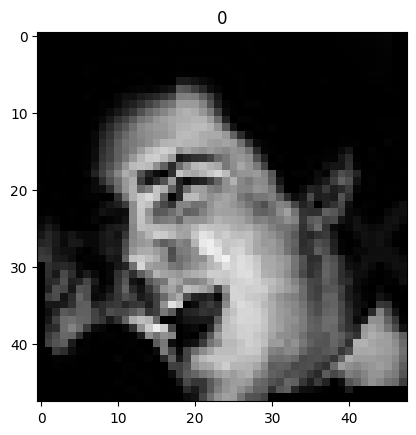

In [11]:
image, label = trainset[40]
plt.imshow(image.permute(1,2,0))
plt.title(label)

# Load Dataset into Batches

In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [14]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [15]:
for images, labels in trainloader:
  break


print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [16]:
import timm
from torch import nn

In [42]:
class FaceModel(nn.Module):

  def __init__(self):
    super(FaceModel, self).__init__()

    self.eff_net_model = timm.create_model("efficientnet_b0", pretrained = True)
    self.eff_net_model.classifier = nn.Linear(self.eff_net_model.classifier.in_features, 7)
    self.criterion = nn.CrossEntropyLoss(reduction='mean')


  def forward(self, images, labels = None):
    logits = self.eff_net_model(images)
    if labels is not None:
      loss = self.criterion(logits, labels)
      return loss, logits

    return logits

In [43]:
model = FaceModel().to(DEVICE)
model

FaceModel(
  (eff_net_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw)

# Create Train and Eval Function

In [36]:
from tqdm import tqdm

In [37]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [38]:
def train_fn(model, dataloader, current_epo):
  model.train()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "Epoch "+"(TRAIN)"+ str(current_epo+1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    loss, logits = model(images, labels) # Corrected unpacking order

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : total_loss/(t+1), 'acc' : total_acc/(t+1)})

  return total_loss/len(dataloader), total_acc/len(dataloader)

In [39]:
def eval_fn(model, dataloader, current_epo):
  model.eval()
  total_loss = 0.0
  total_acc = 0.0
  tk = tqdm(dataloader, desc = "Epoch " +"(VALID)"+ str(current_epo+1) + "/" + str(EPOCHS))

  for t, data in enumerate(tk):
    images, labels = data
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    loss, logits = model(images, labels) # Corrected unpacking order

    total_loss += loss.item()
    total_acc += multiclass_accuracy(logits, labels)
    tk.set_postfix({'loss' : total_loss/(t+1), 'acc' : total_acc/(t+1)})

  return total_loss/len(dataloader), total_acc/len(dataloader)

# Create Training Loop

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):
  train_loss, train_acc = train_fn(model, trainloader, i)
  valid_loss, valid_acc = eval_fn(model, validloader, i)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), "best-weights.pt")
    print("Saved Best Model Weights")
    best_valid_loss = valid_loss

Epoch (VALID)1/15: 100%|██████████| 221/221 [00:06<00:00, 35.39it/s, loss=2, acc=tensor(0.1611)]


Saved Best Model Weights


Epoch (TRAIN)2/15:   6%|▌         | 55/901 [00:03<01:02, 13.49it/s, loss=1.99, acc=tensor(0.1579)]

# Inference

In [ ]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

In [26]:
model = FaceModel().to(DEVICE)